# EDA - Bureau

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 0)

import missingno as msno
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

sns.set_style('darkgrid')
tqdm.pandas()

import sys
sys.path.append('../')
from config import *

じゅんび

In [4]:
train = pd.read_feather('../input/application_train.ftr')
buro = pd.read_feather('../input/bureau.ftr')
bb = pd.read_csv('../input/bureau_balance.csv.zip')

In [5]:
buro = train[['SK_ID_CURR', 'TARGET']].merge(buro, on='SK_ID_CURR', how='right')

In [24]:
buro.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1.0,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.0,0,135000.0,0.0,0.0,0.0,Consumer credit,-1185,0.0
1,100002,1.0,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.0,NaN,NaN,0.0,Credit card,-1038,0.0
2,100002,1.0,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.0,0,19071.0,NaN,NaN,0.0,Consumer credit,-906,0.0
3,100002,1.0,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.0,0,67500.0,NaN,NaN,0.0,Credit card,-758,0.0
4,100002,1.0,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.0,245781.0,0.0,0.0,Consumer credit,-7,0.0


In [26]:
bb

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [25]:
buro.groupby('CREDIT_TYPE').TARGET.mean()

CREDIT_TYPE
Another type of loan                            0.071429
Car loan                                        0.055731
Cash loan (non-earmarked)                       0.043478
Consumer credit                                 0.074837
Credit card                                     0.088009
Interbank credit                                0.000000
Loan for business development                   0.061592
Loan for purchase of shares (margin lending)    0.000000
Loan for the purchase of equipment              0.235294
Loan for working capital replenishment          0.127321
Microloan                                       0.206441
Mobile operator loan                            0.000000
Mortgage                                        0.049978
Real estate loan                                0.000000
Unknown type of loan                            0.061441
Name: TARGET, dtype: float64

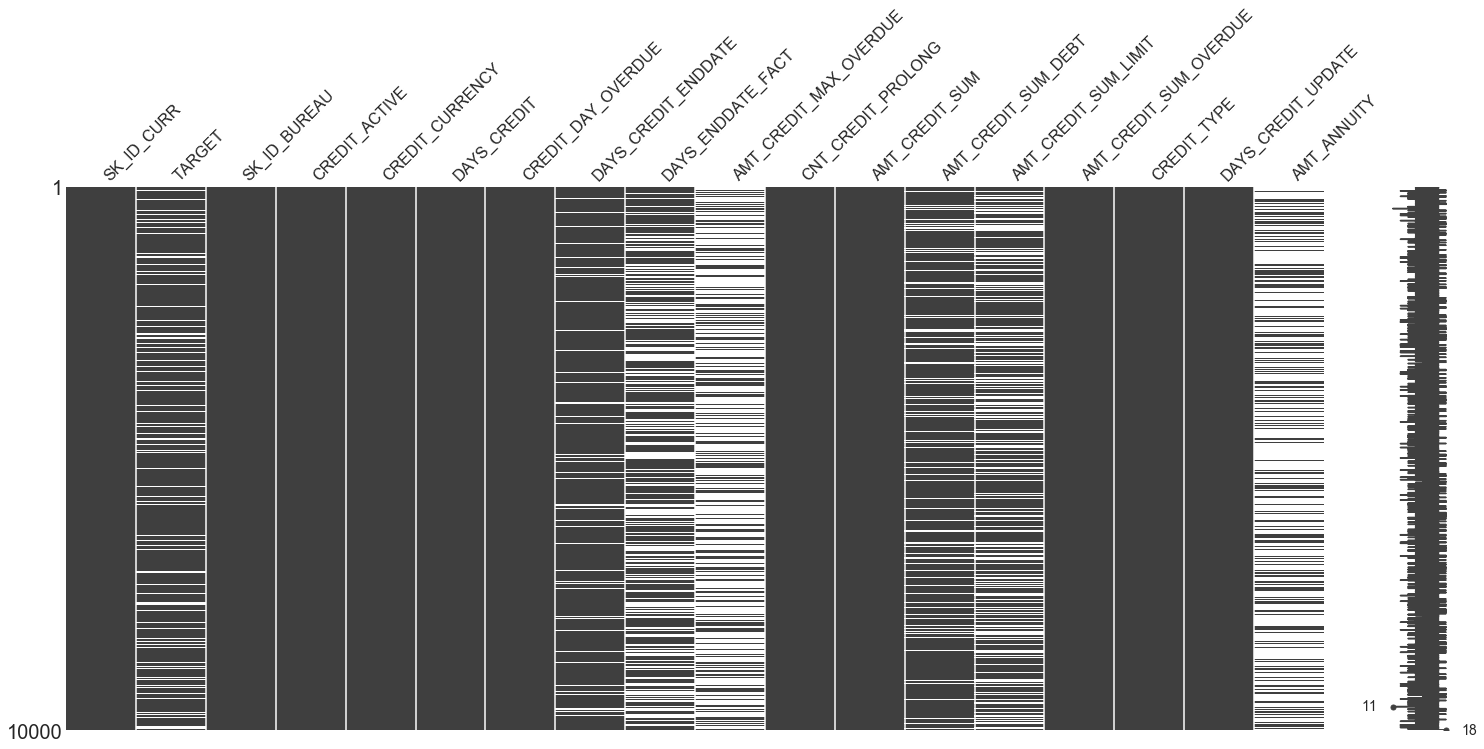

In [4]:
msno.matrix(buro.sample(10000))
plt.show()

CreditTypeをtarget encoding

In [5]:
from sklearn.model_selection import PredefinedSplit
cv_id = pd.read_feather('../input/cv_id.ftr')
cv = PredefinedSplit(cv_id)

In [6]:
df = pd.DataFrame(index=buro.index)
for i, (trn_idx, val_idx) in tqdm(enumerate(cv.split(train.SK_ID_CURR))):
    idx = train.SK_ID_CURR[trn_idx].values
    ref = buro.query('SK_ID_CURR in @idx').groupby('CREDIT_TYPE').TARGET.mean()
    df[i] = (buro.query('SK_ID_CURR not in @idx').CREDIT_TYPE.replace(ref))
    df[i] = df[i].replace(buro.CREDIT_TYPE.unique(), 0).astype(float)
buro['CREDIT_TYPE_ENC'] = df.mean(axis=1)

5it [00:15,  3.01s/it]


bureau balanceのcount

In [7]:
t = buro[['SK_ID_BUREAU']].merge(bb, on='SK_ID_BUREAU', how='left')
t = t.groupby('SK_ID_BUREAU').MONTHS_BALANCE.count().to_frame('BUREAU_BALANCE_COUNT')
buro = buro.merge(t, left_on='SK_ID_BUREAU', right_index=True, how='left')

bureauのcount

In [8]:
t = buro.groupby('SK_ID_CURR').size()

DAY関連

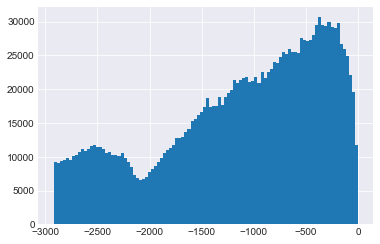

In [278]:
buro.DAYS_CREDIT.hist(bins=100)
plt.show()

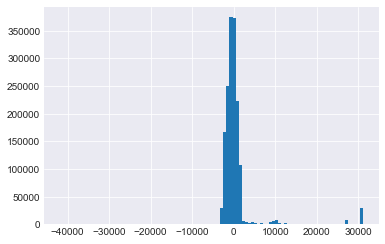

In [276]:
buro.DAYS_CREDIT_ENDDATE.hist(bins=100)
plt.show()

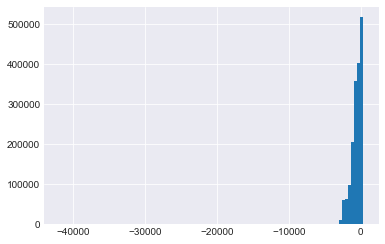

In [280]:
buro.DAYS_CREDIT_UPDATE.hist(bins=100)
plt.show()

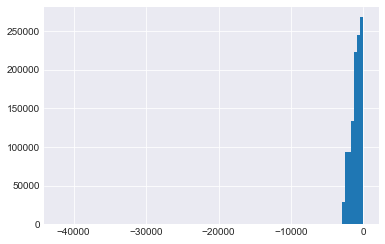

In [17]:
buro.DAYS_ENDDATE_FACT.hist(bins=100)

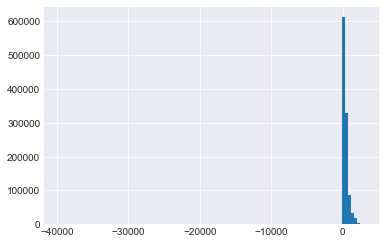

In [42]:
(buro['DAYS_ENDDATE_FACT'] - buro['DAYS_CREDIT']).hist(bins=100)

In [ ]:
msno.

In [40]:
annuity = buro.AMT_ANNUITY
annuity_calc = buro.AMT_CREDIT_SUM / ((buro.DAYS_CREDIT_ENDDATE - buro.DAYS_CREDIT)/30)

In [34]:
diff = annuity_calc - annuity

In [33]:
buro['payment_terms'] = buro['DAYS_CREDIT_ENDDATE']-buro['DAYS_CREDIT']

In [49]:
df = buro.query('SK_ID_CURR == 100003')[['AMT_CREDIT_SUM', 'DAYS_CREDIT', 'DAYS_ENDDATE_FACT']].fillna(0)

In [54]:
res = [df.query('DAYS_CREDIT <= @end <= DAYS_ENDDATE_FACT').AMT_CREDIT_SUM.sum() for end in df.DAYS_ENDDATE_FACT]

(0, 5000)

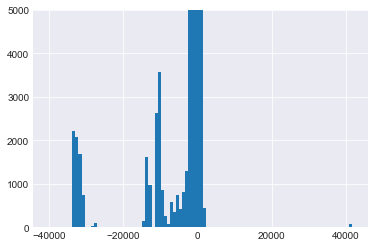

In [295]:
(buro.DAYS_ENDDATE_FACT - buro.DAYS_CREDIT_ENDDATE).hist(bins=100)
plt.ylim([0, 5000])

In [296]:
buro['prepayment'] = buro.DAYS_ENDDATE_FACT - buro.DAYS_CREDIT_ENDDATE

In [299]:
buro.groupby('SK_ID_CURR').prepayment.agg({'min', 'mean', 'median', 'max'})

,min,mean,max,median
SK_ID_CURR,,,,
100001,-698.0,-197.000000,1.0,-45.5
100002,-1029.0,-252.600000,0.0,-113.0
100003,-201.0,34.000000,303.0,0.0
100004,-88.0,-44.000000,0.0,-44.0
100005,5.0,5.000000,5.0,5.0
100007,0.0,0.000000,0.0,0.0
100008,-175.0,-86.500000,2.0,-86.5
100009,-1459.0,-114.785714,713.0,0.0
100010,-210.0,-210.000000,-210.0,-210.0


In [288]:
buro.query('CREDIT_ACTIVE == "Active"').groupby('SK_ID_CURR').CREDIT_DA_OVERDUE

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BUREAU_BALANCE_COUNT,CREDIT_TYPE_ENC
4,100002,1.0,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.000,0.000,0.0,Consumer credit,-7,0.000,16,0.074707
7,100002,1.0,6158909,Active,currency 1,-103,0,NaN,NaN,40.50,0,31988.565,0.000,31988.565,0.0,Credit card,-24,0.000,4,0.087814
11,100003,0.0,5885880,Active,currency 1,-606,0,1216.0,NaN,0.00,0,810000.000,0.000,810000.000,0.0,Credit card,-43,NaN,0,0.088418
17,100008,0.0,6491434,Active,currency 1,-78,0,471.0,NaN,0.00,0,267606.000,240057.000,0.000,0.0,Consumer credit,-16,NaN,0,0.074707
26,100009,0.0,5651009,Active,currency 1,-1293,0,NaN,NaN,NaN,0,187200.000,0.000,NaN,0.0,Credit card,-847,NaN,0,0.087894
33,100009,0.0,5651004,Active,currency 1,-424,0,1402.0,NaN,NaN,0,642861.000,557959.500,0.000,0.0,Consumer credit,-27,NaN,0,0.074402
34,100009,0.0,5651010,Active,currency 1,-411,0,NaN,NaN,NaN,0,360000.000,192762.000,NaN,0.0,Consumer credit,-23,NaN,0,0.074402
35,100009,0.0,5651003,Active,currency 1,-239,0,-209.0,NaN,NaN,0,337500.000,326628.000,0.000,0.0,Credit card,-86,NaN,0,0.087894
37,100010,0.0,5576630,Active,currency 1,-1138,0,689.0,NaN,NaN,0,675000.000,348007.500,0.000,0.0,Consumer credit,-18,NaN,36,0.075090
48,100014,0.0,5326772,Active,currency 1,-423,0,704.0,NaN,12752.28,0,571500.000,420201.000,0.000,0.0,Consumer credit,-25,NaN,0,0.074707


In [281]:
buro.describe()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BUREAU_BALANCE_COUNT,CREDIT_TYPE_ENC
count,1.716428e+06,1.465325e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05,1.716428e+06,1.716428e+06
mean,2.782149e+05,7.815331e-02,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04,1.408724e+01,7.829413e-02
std,1.029386e+05,2.684128e-01,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05,2.214124e+01,1.298197e-02
min,1.000010e+05,0.000000e+00,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.888668e+05,0.000000e+00,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00,0.000000e+00,7.450952e-02
50%,2.780550e+05,0.000000e+00,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00,0.000000e+00,7.483669e-02
75%,3.674260e+05,0.000000e+00,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04,2.200000e+01,7.547510e-02
max,4.562550e+05,1.000000e+00,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08,9.700000e+01,3.076923e-01


In [272]:
abs(buro.groupby('SK_ID_CURR').DAYS_CREDIT.min()) / buro.groupby('SK_ID_CURR').size()

SK_ID_CURR
100001     224.571429
100002     179.625000
100003     646.500000
100004     663.000000
100005     124.333333
100007    1149.000000
100008     365.666667
100009     160.111111
100010    1370.500000
100011     627.000000
100013     517.500000
100014     288.500000
100015     352.250000
100016     233.428571
100017     480.166667
100019     247.500000
100020     123.000000
100022     192.500000
100023     201.846154
100025     700.000000
100026     548.000000
100027     661.000000
100028     175.416667
100029     701.500000
100030     257.833333
100031     195.000000
100032     347.250000
100033     195.000000
100035     302.555556
100036     889.000000
             ...     
456220     318.800000
456221     267.400000
456223     203.400000
456224     161.058824
456225     201.444444
456226     374.000000
456227     603.250000
456229    1839.000000
456230     175.166667
456231     259.571429
456232     382.000000
456233     203.000000
456234     120.100000
456235     918.000000

In [ ]:
buro.groupby('CREDIT_ACTIVE.')

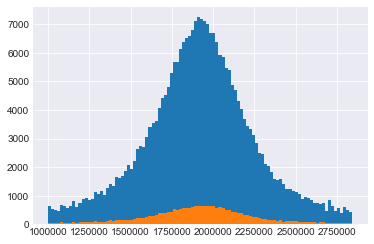

In [41]:
prev_group = prev.groupby('SK_ID_CURR', as_index=False).SK_ID_PREV.mean()

df = train.merge(prev_group, on='SK_ID_CURR')

df.loc[df.TARGET==0, 'SK_ID_PREV'].hist(bins=100)
df.loc[df.TARGET==1, 'SK_ID_PREV'].hist(bins=100)
plt.show()

In [27]:
df = pd.read_feather('../working/bureau_active_and_type_product_train.ftr')
df

,bureau_Active_Another type of loan_count,bureau_Active_Car loan_count,bureau_Active_Cash loan (non-earmarked)_count,bureau_Active_Consumer credit_count,bureau_Active_Credit card_count,bureau_Active_Loan for business development_count,bureau_Active_Loan for purchase of shares (margin lending)_count,bureau_Active_Loan for the purchase of equipment_count,bureau_Active_Loan for working capital replenishment_count,bureau_Active_Microloan_count,bureau_Active_Mobile operator loan_count,bureau_Active_Mortgage_count,bureau_Active_Real estate loan_count,bureau_Active_Unknown type of loan_count,bureau_Bad debt_Consumer credit_count,bureau_Bad debt_Credit card_count,bureau_Closed_Another type of loan_count,bureau_Closed_Car loan_count,bureau_Closed_Cash loan (non-earmarked)_count,bureau_Closed_Consumer credit_count,bureau_Closed_Credit card_count,bureau_Closed_Interbank credit_count,bureau_Closed_Loan for business development_count,bureau_Closed_Loan for purchase of shares (margin lending)_count,bureau_Closed_Loan for the purchase of equipment_count,bureau_Closed_Loan for working capital replenishment_count,bureau_Closed_Microloan_count,bureau_Closed_Mortgage_count,bureau_Closed_Real estate loan_count,bureau_Closed_Unknown type of loan_count,bureau_Sold_Another type of loan_count,bureau_Sold_Car loan_count,bureau_Sold_Cash loan (non-earmarked)_count,bureau_Sold_Consumer credit_count,bureau_Sold_Credit card_count,bureau_Sold_Loan for business development_count,bureau_Sold_Loan for working capital replenishment_count,bureau_Sold_Microloan_count,bureau_Sold_Mortgage_count,bureau_Sold_Real estate loan_count,bureau_Active_Another type of loan_ratio,bureau_Active_Car loan_ratio,bureau_Active_Cash loan (non-earmarked)_ratio,bureau_Active_Consumer credit_ratio,bureau_Active_Credit card_ratio,bureau_Active_Loan for business development_ratio,bureau_Active_Loan for purchase of shares (margin lending)_ratio,bureau_Active_Loan for the purchase of equipment_ratio,bureau_Active_Loan for working capital replenishment_ratio,bureau_Active_Microloan_ratio,bureau_Active_Mobile operator loan_ratio,bureau_Active_Mortgage_ratio,bureau_Active_Real estate loan_ratio,bureau_Active_Unknown type of loan_ratio,bureau_Bad debt_Consumer credit_ratio,bureau_Bad debt_Credit card_ratio,bureau_Closed_Another type of loan_ratio,bureau_Closed_Car loan_ratio,bureau_Closed_Cash loan (non-earmarked)_ratio,bureau_Closed_Consumer credit_ratio,bureau_Closed_Credit card_ratio,bureau_Closed_Interbank credit_ratio,bureau_Closed_Loan for business development_ratio,bureau_Closed_Loan for purchase of shares (margin lending)_ratio,bureau_Closed_Loan for the purchase of equipment_ratio,bureau_Closed_Loan for working capital replenishment_ratio,bureau_Closed_Microloan_ratio,bureau_Closed_Mortgage_ratio,bureau_Closed_Real estate loan_ratio,bureau_Closed_Unknown type of loan_ratio,bureau_Sold_Another type of loan_ratio,bureau_Sold_Car loan_ratio,bureau_Sold_Cash loan (non-earmarked)_ratio,bureau_Sold_Consumer credit_ratio,bureau_Sold_Credit card_ratio,bureau_Sold_Loan for business development_ratio,bureau_Sold_Loan for working capital replenishment_ratio,bureau_Sold_Microloan_ratio,bureau_Sold_Mortgage_ratio,bureau_Sold_Real estate loan_ratio
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125000,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.375000,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0

In [31]:
df.loc[:, df.var() > 1e-3]

,bureau_Active_Car loan_count,bureau_Active_Consumer credit_count,bureau_Active_Credit card_count,bureau_Active_Loan for business development_count,bureau_Active_Microloan_count,bureau_Active_Mortgage_count,bureau_Closed_Another type of loan_count,bureau_Closed_Car loan_count,bureau_Closed_Consumer credit_count,bureau_Closed_Credit card_count,bureau_Closed_Loan for business development_count,bureau_Closed_Loan for working capital replenishment_count,bureau_Closed_Microloan_count,bureau_Closed_Mortgage_count,bureau_Closed_Unknown type of loan_count,bureau_Sold_Car loan_count,bureau_Sold_Consumer credit_count,bureau_Sold_Credit card_count,bureau_Sold_Mortgage_count,bureau_Active_Car loan_ratio,bureau_Active_Consumer credit_ratio,bureau_Active_Credit card_ratio,bureau_Active_Mortgage_ratio,bureau_Closed_Car loan_ratio,bureau_Closed_Consumer credit_ratio,bureau_Closed_Credit card_ratio,bureau_Closed_Microloan_ratio,bureau_Closed_Mortgage_ratio
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.125000,0.000000,0.000000,0.375000,0.375000,0.0,0.00
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.500000,0.250000,0.0,0.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.00
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.00
6,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.000000,0.000000,0.777778,0.000000,0.0,0.00
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.250000,0.0,0.00
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
bureau = pd.read_feather(INPUT / 'bureau.ftr')
bureau_balance = pd.read_feather(INPUT / 'bureau_balance.ftr')
display(bureau.head())
display(bureau_balance.head())

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [25]:
bureau.query('CREDIT_ACTIVE=="Active"')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.000,113166.000,0.000,0.0,Consumer credit,-6,4630.500
248490,100001,5896636,Active,currency 1,-320,0,411.0,NaN,NaN,0,168345.000,110281.500,NaN,0.0,Consumer credit,-10,9364.500
248489,100001,5896635,Active,currency 1,-49,0,1778.0,NaN,NaN,0,378000.000,373239.000,0.000,0.0,Consumer credit,-16,10822.500
1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.000,0.000,0.0,Consumer credit,-7,0.000
675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.000,31988.565,0.0,Credit card,-24,0.000
1024669,100003,5885880,Active,currency 1,-606,0,1216.0,NaN,0.000,0,810000.000,0.000,810000.000,0.0,Credit card,-43,NaN
1421815,100005,6735201,Active,currency 1,-137,0,1324.0,NaN,NaN,0,568800.000,543087.000,0.000,0.0,Consumer credit,-11,0.000
1421816,100005,6735202,Active,currency 1,-62,0,122.0,NaN,0.000,0,29826.000,25321.500,0.000,0.0,Consumer credit,-31,4261.500
718762,100008,6491434,Active,currency 1,-78,0,471.0,NaN,0.000,0,267606.000,240057.000,0.000,0.0,Consumer credit,-16,NaN
1279723,100009,5651009,Active,currency 1,-1293,0,NaN,NaN,NaN,0,187200.000,0.000,NaN,0.0,Credit card,-847,NaN


In [24]:
bureau.CREDIT_TYPE.str.replace(' ', '_')

248487          Consumer_credit
248485          Consumer_credit
248486          Consumer_credit
248484          Consumer_credit
248488          Consumer_credit
248490          Consumer_credit
248489          Consumer_credit
675686          Consumer_credit
675684              Credit_card
675687          Consumer_credit
1486113             Credit_card
1337779         Consumer_credit
675688          Consumer_credit
675685              Credit_card
675689              Credit_card
1024666         Consumer_credit
1024667             Credit_card
1024668         Consumer_credit
1024669             Credit_card
363104          Consumer_credit
363105          Consumer_credit
1421814             Credit_card
1421815         Consumer_credit
1421816         Consumer_credit
1503966         Consumer_credit
718761          Consumer_credit
1616817         Consumer_credit
718762          Consumer_credit
1279720         Consumer_credit
1279725         Consumer_credit
                   ...         
1534302 

In [22]:
(bureau['CREDIT_ACTIVE'] + ' '+ bureau['CREDIT_TYPE']).str.replace(' ', '_')

248487          Closed_Consumer_credit
248485          Closed_Consumer_credit
248486          Closed_Consumer_credit
248484          Closed_Consumer_credit
248488          Active_Consumer_credit
248490          Active_Consumer_credit
248489          Active_Consumer_credit
675686          Closed_Consumer_credit
675684              Closed_Credit_card
675687          Closed_Consumer_credit
1486113             Closed_Credit_card
1337779         Active_Consumer_credit
675688          Closed_Consumer_credit
675685              Closed_Credit_card
675689              Active_Credit_card
1024666         Closed_Consumer_credit
1024667             Closed_Credit_card
1024668         Closed_Consumer_credit
1024669             Active_Credit_card
363104          Closed_Consumer_credit
363105          Closed_Consumer_credit
1421814             Closed_Credit_card
1421815         Active_Consumer_credit
1421816         Active_Consumer_credit
1503966         Closed_Consumer_credit
718761          Closed_Co

In [4]:
bureau.sort_values(['SK_ID_CURR', 'DAYS_CREDIT'], inplace=True)

In [ ]:
count = bureau.groupby('SK_ID_CURR').CREDIT_ACTIVE.value_counts().unstack()

In [43]:
bureau_balance.groupby('SK_ID_BUREAU').head(1)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
27,5715449,0,C
39,5715451,-5,C
65,5715452,0,C
98,5715453,0,C
136,5715454,-15,C
175,5715455,-49,X
213,5715456,-21,X
240,5715457,0,0
248,5715458,0,C


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d978400>,
      dtype=object)

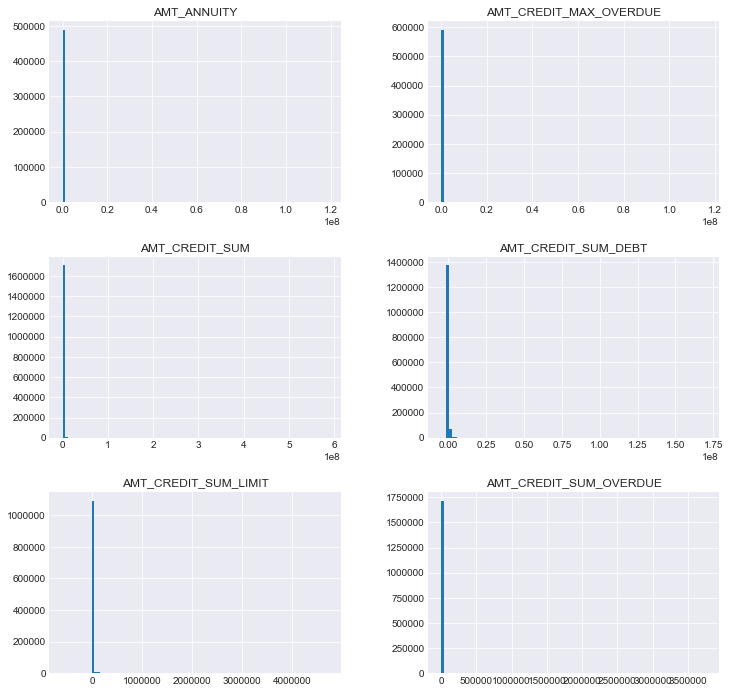

In [14]:
bureau.filter(regex='AMT_').hist(bins=100, figsize=(12, 12))

In [16]:
bureau.filter(regex='AMT_').min()

AMT_CREDIT_MAX_OVERDUE          0.000
AMT_CREDIT_SUM                  0.000
AMT_CREDIT_SUM_DEBT      -4705600.320
AMT_CREDIT_SUM_LIMIT      -586406.115
AMT_CREDIT_SUM_OVERDUE          0.000
AMT_ANNUITY                     0.000
dtype: float64

In [20]:
bureau[bureau.AMT_CREDIT_SUM_DEBT < 0]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
272931,100044,5057756,Active,currency 1,-1827,0,660.0,NaN,18406.935,0,135000.0,-130.005,418630.005,0.0,Credit card,-651,NaN
272932,100044,5057757,Active,currency 1,-1739,0,1178.0,NaN,1125.000,0,22500.0,-78.885,247578.885,0.0,Credit card,-654,NaN
911914,100094,5676240,Closed,currency 1,-1049,0,-379.0,-530.0,0.000,0,4500.0,-0.405,4500.405,0.0,Credit card,-530,NaN
1417579,100138,6173245,Active,currency 1,-964,0,818.0,NaN,0.000,0,0.0,-44390.565,44390.565,0.0,Credit card,-690,NaN
948672,100190,5827339,Active,currency 1,-833,0,975.0,NaN,0.000,0,0.0,-56.790,56.790,0.0,Credit card,-620,NaN
948673,100190,5827340,Closed,currency 1,-809,0,1006.0,-649.0,0.000,0,135000.0,-20.970,135020.970,0.0,Credit card,-649,NaN
1709304,100219,5031754,Active,currency 1,-1033,0,768.0,NaN,0.000,0,0.0,-88.830,88.830,0.0,Credit card,-668,NaN
1101940,100251,5777090,Closed,currency 1,-1741,0,800.0,-525.0,0.000,0,0.0,-4197.195,4197.195,0.0,Credit card,-525,NaN
1101941,100251,5777091,Closed,currency 1,-1734,0,-630.0,-920.0,13768.965,0,135000.0,-39.510,39.510,0.0,Credit card,-920,NaN
1493736,100254,6336844,Closed,currency 1,-2188,0,-1459.0,-1708.0,20592.990,0,225000.0,-12.420,225012.420,0.0,Credit card,-1708,NaN


In [15]:
buro_bal = bureau_balance.groupby('SK_ID_BUREAU') \
    .STATUS.value_counts().unstack('STATUS').fillna(0).astype(int)

buro_bal.columns = 'status_' + buro_bal.columns + '_cnt'

buro_bal['months_cnt'] = bureau_balance.groupby('SK_ID_BUREAU').MONTHS_BALANCE.size()
buro_bal['months_max'] = bureau_balance.groupby('SK_ID_BUREAU').MONTHS_BALANCE.max()
buro_bal['months_min'] = bureau_balance.groupby('SK_ID_BUREAU').MONTHS_BALANCE.min()

for f in tqdm(buro_bal.filter(regex='status_').columns):
    buro_bal[f.replace('_cnt', '_ratio')] = buro_bal[f] / buro_bal.months_cnt

buro = bureau.merge(buro_bal.reset_index(), how='left', on='SK_ID_BUREAU')

100%|██████████| 8/8 [00:00<00:00, 129.31it/s]


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [19]:
buro_cat = [f for f in buro.columns if buro[f].dtype == 'object']
for f in tqdm(buro_cat):
    buro[f] = le.fit_transform(buro[f].astype(str))
    nunique = buro[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    nunique = nunique[f].reset_index().rename(columns={f: 'nunique_'+f})
    buro = buro.merge(nunique, on='SK_ID_CURR', how='left')
    buro.drop(f, axis=1, inplace=True)

100%|██████████| 3/3 [00:25<00:00,  8.48s/it]


In [21]:
avg_buro = buro.groupby('SK_ID_CURR').mean()

In [24]:
train = pd.read_feather(INPUT / 'application_train.ftr')
test = pd.read_feather(INPUT / 'application_test.ftr')

In [28]:
avg_buro.drop('SK_ID_BUREAU', axis=1, inplace=True)
avg_buro.columns = 'bureau_' + avg_buro.columns

In [32]:
train.merge(avg_buro, left_on='SK_ID_CURR', right_index=True, how='left').filter(regex='bureau_')

,bureau_DAYS_CREDIT,bureau_CREDIT_DAY_OVERDUE,bureau_DAYS_CREDIT_ENDDATE,bureau_DAYS_ENDDATE_FACT,bureau_AMT_CREDIT_MAX_OVERDUE,bureau_CNT_CREDIT_PROLONG,bureau_AMT_CREDIT_SUM,bureau_AMT_CREDIT_SUM_DEBT,bureau_AMT_CREDIT_SUM_LIMIT,bureau_AMT_CREDIT_SUM_OVERDUE,bureau_DAYS_CREDIT_UPDATE,bureau_AMT_ANNUITY,bureau_status_0_cnt,bureau_status_1_cnt,bureau_status_2_cnt,bureau_status_3_cnt,bureau_status_4_cnt,bureau_status_5_cnt,bureau_status_C_cnt,bureau_status_X_cnt,bureau_months_cnt,bureau_months_max,bureau_months_min,bureau_status_0_ratio,bureau_status_1_ratio,bureau_status_2_ratio,bureau_status_3_ratio,bureau_status_4_ratio,bureau_status_5_ratio,bureau_status_C_ratio,bureau_status_X_ratio,bureau_nunique_CREDIT_ACTIVE,bureau_nunique_CREDIT_CURRENCY,bureau_nunique_CREDIT_TYPE
0,-874.000000,0.0,-349.000000,-697.500000,1681.029000,0.000000,1.081319e+05,4.915620e+04,7997.14125,0.000,-499.875000,0.000000,5.625000,3.375000,0.000000,0.000000,0.000000,0.000000,2.875000,1.875000,13.750000,-15.500000,-28.250000,0.406960,0.255682,0.000000,0.00000,0.00000,0.00000,0.175426,0.161932,2.0,1.0,2.0
1,-1400.750000,0.0,-544.500000,-1097.333333,0.000000,0.000000,2.543501e+05,0.000000e+00,202500.00000,0.000,-816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0
2,-867.000000,0.0,-488.500000,-532.500000,0.000000,0.000000,9.451890e+04,0.000000e+00,0.00000,0.000,-532.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1149.000000,0.0,-783.000000,-783.000000,0.000000,0.000000,1.462500e+05,0.000000e+00,0.00000,0.000,-783.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
5,-757.333333,0.0,-391.333333,-909.000000,0.000000,0.000000,1.561485e+05,8.001900e+04,0.00000,0.000,-611.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0
6,-1271.500000,0.0,-794.937500,-1108.500000,0.000000,0.000000,2.667118e+05,7.695354e+04,0.00000,0.000,-851.611111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0
7,-1939.500000,0.0,-119.500000,-1138.000000,NaN,0.000000,4.950000e+05,1.740038e+05,0.00000,0.000,-578.000000,NaN,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,36.000000,-28.500000,-63.500000,0.277778,0.000000,0.000000,0.00000,0.00000,0.00000,0.722222,0.000000,2.0,1.0,2.0
8,-1773.000000,0.0,-1293.250000,-1463.250000,5073.615000,0.000000,1.088071e+05,0.000000e+00,0.00000,0.000,-1454.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df = pd.read_feather(WORKING / 'bureau_train.ftr')

In [35]:
df.shape

(307511, 36)

In [16]:
buro.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,status_0_cnt,status_1_cnt,status_2_cnt,status_3_cnt,status_4_cnt,status_5_cnt,status_C_cnt,status_X_cnt,months_cnt,months_max,months_min,status_0_ratio,status_1_ratio,status_2_ratio,status_3_ratio,status_4_ratio,status_5_ratio,status_C_ratio,status_X_ratio
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bureau_balance.STATUS.value_counts()

In [ ]:
msno.matrix(bureau.sample(300))
plt.show()

msno.heatmap(bureau)
plt.show()

In [ ]:
counts = bureau.SK_ID_CURR.value_counts()
counts.hist(bins=counts.max()-counts.min())
plt.title('SK_ID_CURR counts')
plt.show()

In [ ]:
bureau.DAYS_CREDIT.hist(bins=100)
plt.title('DAYS_CREDIT hist')
plt.show()

In [ ]:
plt.hist(bureau.CREDIT_DAY_OVERDUE, bins=100, log=True)
plt.show()

In [ ]:
bureau[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby('SK_ID_CURR').CNT_CREDIT_PROLONG.max().value_counts().sort_index()

In [ ]:
bureau.AMT_CREDIT_SUM.hist(bins=100, log=True)

In [ ]:
np.log1p(bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby('SK_ID_CURR').mean()).hist(bins=100)
plt.show()

In [ ]:
np.log1p(bureau.AMT_CREDIT_SUM_DEBT[bureau.AMT_CREDIT_SUM_DEBT!=0]).hist(bins=100)
plt.show()

In [ ]:
np.log1p(bureau.AMT_CREDIT_SUM_LIMIT[bureau.AMT_CREDIT_SUM_LIMIT!=0]).hist(bins=100)

In [ ]:
bureau.CREDIT_TYPE.value_counts()

In [ ]:
bureau.DAYS_CREDIT_ENDDATE.hist(bins=100, log=True)

In [ ]:
bureau.CREDIT_CURRENCY.value_counts()

In [ ]:
bureau.CREDIT_ACTIVE.value_counts()

In [ ]:
nunique = bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']].groupby('SK_ID_CURR').CREDIT_ACTIVE.nunique()
nunique.value_counts()

In [ ]:
bureau

In [ ]:
bureau.query("SK_ID_CURR in @nunique.to_frame().query('CREDIT_ACTIVE==1').index")

In [ ]:
bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']].groupby('SK_ID_CURR').